# Ch4_AutoEncoder_MLP

In [34]:
import numpy as np
import sklearn.preprocessing as prep
import tensorflow as tf 
from tensorflow.examples.tutorials.mnist import input_data

In [35]:
# initialize weight
# use xavier_init or batch normalization
def xavier_init(fan_in, fan_out, constant=1):
    low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
    high = constant * np.sqrt(6.0 / (fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), minval = low, maxval = high, dtype = tf.float32)

# standardize training and testing set
def standard_scale(X_train, X_test):
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    return X_train, X_test

def get_random_block_from_data(data, batch_size):
    start_index = np.random.randint(0, len(data) - batch_size)
    return data[start_index: start_index + batch_size]

In [38]:
class AdditiveGaussianNoiseAutoencoder(object):
    def __init__(self, n_input, n_hidden, transfer_function = tf.nn.softplus, 
                 optimizer = tf.train.AdamOptimizer(), scale = 0.1):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.transfer = transfer_function
        self.scale = tf.placeholder(tf.float32)
        self.training_scale = scale
        # network_weights = self._initialize_weights()
        # self.weights = network_weights
        self.weights = self._initialize_weights()
        
        self.x = tf.placeholder(tf.float32, [None, self.n_input])
        self.hidden = self.transfer(tf.add(tf.matmul(self.x + self.scale * tf.random_normal((self.n_input, )),
                                                    self.weights['w1']), self.weights['b1']))
        self.reconstruction = tf.add(tf.matmul(self.hidden, self.weights['w2']), self.weights['b2'])
        
        # (out - in)^2
        self.cost = 0.5 * tf.reduce_sum(tf.pow(tf.subtract(self.reconstruction, self.x), 2.0))
        self.optimizer = optimizer.minimize(self.cost)
        # initialize all variable
        # once your define a variable (here is our weight), you will need to initialize it at the beginning
        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)
        
    def _initialize_weights(self):
        all_weights = dict()
        all_weights['w1'] = tf.Variable(xavier_init(self.n_input, self.n_hidden))
        all_weights['b1'] = tf.Variable(tf.zeros([self.n_hidden], dtype = tf.float32))
        all_weights['w2'] = tf.Variable(tf.zeros([self.n_hidden, self.n_input], dtype = tf.float32))
        all_weights['b2'] = tf.Variable(tf.zeros([self.n_input], dtype = tf.float32))
        return all_weights
    def partial_fit(self, X):
        cost, opt = self.sess.run((self.cost, self.optimizer), 
                                  feed_dict = {self.x : X, self.scale : self.training_scale})
        return cost
    def calc_total_cost(self, X):
        return self.sess.run(self.cost, 
                             feed_dict = {self.x : X, self.scale : self.training_scale})
    # encoder
    def transform(self, X):
        return self.sess.run(self.hidden, feed_dict = {self.x : X, self.scale : self.training_scale})

    # decoder 
    def generate(self, hidden = None):
        if hidden is None:
            hidden = np.random.normal(size = self.weights["b1"])
        return self.sess.run(self.reconstruction, feed_dict = {self.hidden: hidden})
    
    def reconstruct(self, X):
        return self.sess.run(self.reconstruction, feed_dict = {self.x : X, self.scale : self.training_scale})
    
    def getWeights(self):
        return self.sess.run(self.weights['w1'])
    
    def getBiases(self):
        return self.sess.run(self.weights['b1'])

In [39]:
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)
X_train, X_test = standard_scale(mnist.train.images, mnist.test.images)

n_samples = int(mnist.train.num_examples)
training_epochs = 20
bbatch_size = 128
batch_size = 128
display_step = 1

autoencoder = AdditiveGaussianNoiseAutoencoder(n_input = 784,
                                              n_hidden = 200,
                                              transfer_function = tf.nn.softplus,
                                              optimizer = tf.train.AdamOptimizer(learning_rate=0.001),
                                              scale = 0.01)

for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(n_samples / batch_size)
    for i in range(total_batch):
        batch_xs = get_random_block_from_data(X_train, batch_size)
        
        cost = autoencoder.partial_fit(batch_xs)
        avg_cost += cost / n_samples * batch_size
        
    if epoch % display_step == 0:
        print("Epoch:",'%04d' % (epoch + 1), "cost=", "{:.9f}".format(avg_cost))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch: 0001 cost= 19931.466657955
Epoch: 0002 cost= 12542.964593182
Epoch: 0003 cost= 11367.437498864
Epoch: 0004 cost= 9665.450399432
Epoch: 0005 cost= 9435.036511932
Epoch: 0006 cost= 9606.118285227
Epoch: 0007 cost= 9099.525119318
Epoch: 0008 cost= 8916.995691477
Epoch: 0009 cost= 8702.376978409
Epoch: 0010 cost= 8843.548801136
Epoch: 0011 cost= 8182.707768182
Epoch: 0012 cost= 7967.103618182
Epoch: 0013 cost= 7906.763730114
Epoch: 0014 cost= 7597.109608523
Epoch: 0015 cost= 8595.696171023
Epoch: 0016 cost= 8096.493884091
Epoch: 0017 cost= 7879.155425568
Epoch: 0018 cost= 8044.256097727
Epoch: 0019 cost= 7927.524327841
Epoch: 0020 cost= 7860.495647727


In [32]:
print("total cost:" + str(autoencoder.calc_total_cost(X_test)))

total cost:662981.8


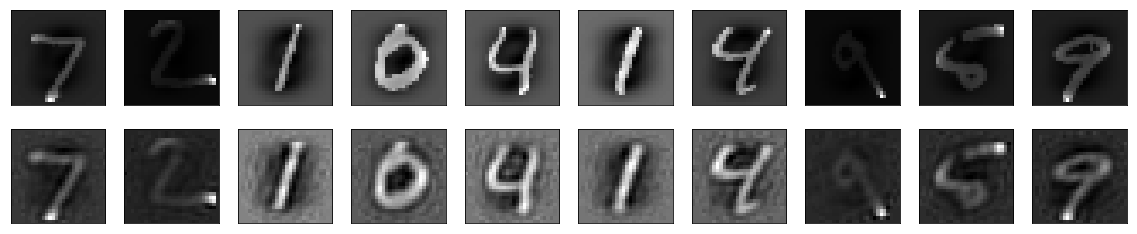

In [76]:
import matplotlib.pyplot as plt
output = autoencoder.reconstruct(X_test)
test = np.reshape(output, (output.shape[0],28,28))

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [87]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)
sess = tf.InteractiveSession()
in_units = 784
h1_units = 300
W1 = tf.Variable(tf.truncated_normal([in_units,h1_units], stddev = 0.1))
b1 = tf.Variable(tf.zeros([h1_units]))
W2 = tf.Variable(tf.zeros([h1_units, 10]))
b2 = tf.Variable(tf.zeros([10]))

x = tf.placeholder(tf.float32, [None, in_units])
keep_prob = tf.placeholder(tf.float32)

hidden1 = tf.nn.relu(tf.matmul(x, W1) + b1)
hidden1_drop = tf.nn.dropout(hidden1, keep_prob)
y = tf.nn.softmax(tf.matmul(hidden1_drop, W2) + b2)

y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices = [1]))
train_step = tf.train.AdagradOptimizer(0.3).minimize(cross_entropy)

tf.global_variables_initializer().run()
for i in range(3000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    train_step.run({x: batch_xs, y_: batch_ys, keep_prob: 0.75})
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0.205
0.1789
0.3774
0.5079
0.6605
0.6839
0.6899
0.5585
0.6682
0.6294
0.7151
0.706
0.7181
0.7964
0.7618
0.654
0.6141
0.6143
0.6209
0.677
0.7302
0.8525
0.8091
0.8318
0.7047
0.7594
0.7461
0.8354
0.8345
0.8242
0.8527
0.8484
0.8707
0.8554
0.8555
0.8643
0.8663
0.8645
0.8716
0.8866
0.8699
0.8825
0.8748
0.8192
0.7922
0.8685
0.8804
0.8562
0.8755
0.8797
0.8829
0.887
0.8884
0.8442
0.8793
0.8782
0.8996
0.8924
0.8959
0.8562
0.9062
0.8595
0.8969
0.902
0.8457
0.8459
0.909
0.9138
0.9085
0.8982
0.9019
0.9102
0.9097
0.8904
0.8994
0.9129
0.9143
0.8952
0.9095
0.8977
0.8881
0.9079
0.9022
0.9075
0.9188
0.9099
0.9157
0.9008
0.9072
0.9204
0.9219
0.9026
0.9031
0.9225
0.9178
0.9153
0.9247
0.9158
0.8995
0.9035
0.9153
0.9161
0.9266
0.9185
0.9132
0.9027
0.901
0.926
0.922
0.9122
0.8846
0.9059
0.9261
0.9175
0.9252
0.8904
0.92

0.9706
0.9707
0.9702
0.9707
0.9703
0.9713
0.9701
0.9723
0.9712
0.9718
0.9716
0.9706
0.9706
0.971
0.9707
0.969
0.97
0.9708
0.9718
0.9715
0.9711
0.969
0.9677
0.9703
0.9715
0.9708
0.971
0.9714
0.9719
0.9717
0.9695
0.9695
0.9713
0.9722
0.9699
0.9701
0.9723
0.9713
0.9715
0.9658
0.9684
0.9701
0.969
0.9704
0.9732
0.9735
0.9743
0.973
0.9732
0.9704
0.9708
0.9724
0.9736
0.9707
0.9729
0.9739
0.9736
0.9731
0.9734
0.9728
0.9726
0.9716
0.9703
0.9723
0.9729
0.973
0.9738
0.9737
0.9721
0.9734
0.9726
0.9734
0.9709
0.9718
0.9695
0.9694
0.9724
0.9724
0.974
0.9739
0.9734
0.9737
0.9745
0.9733
0.9735
0.9734
0.9741
0.9733
0.9733
0.974
0.9734
0.9738
0.9733
0.9729
0.9722
0.9705
0.9705
0.9723
0.9733
0.9725
0.9738
0.9725
0.9744
0.9742
0.9714
0.9741
0.9707
0.9702
0.9711
0.9689
0.97
0.9713
0.9717
0.9695
0.9704
0.972
0.9735
0.9733
0.9736
0.9739
0.9734
0.9734
0.9737
0.9743
0.9746
0.9733
0.9736
0.9729
0.9739
0.973
0.9731
0.9733
0.9743
0.9743
0.9746
0.9732
0.972
0.9732
0.9718
0.9739
0.9732
0.9731
0.972
0.9724
0.9716
0.

0.9757
0.9767
0.9771
0.9773
0.9755
0.977
0.9772
0.9772
0.9775
0.9771
0.9737
0.9773
0.9775
0.9777
0.9769
0.9766
0.9768
0.9752
0.9751
0.9766
0.9767
0.9767
0.977
0.9769
0.977
0.9785
0.9788
0.9788
0.9784
0.9792
0.9772
0.9784
0.9787
0.9783
0.9785
0.9776
0.9791
0.9782
0.9777
0.9777
0.9775
0.9782
0.9773
0.9782
0.9781
0.9767
0.9768
0.9761
0.9761
0.9758
0.9755
0.9773
0.9781
0.9781
0.9778
0.9775
0.978
0.9782
0.977
0.978
0.9776
0.9784
0.9774
0.9778
0.9784
0.9786
0.9781
0.9757
0.9766
0.9775
0.9782
0.9775
0.9783
0.9766
0.9753
0.9758
0.9764
0.9768
0.974
0.9745
0.9761
0.9773
0.9786
0.9785
0.9779
0.9781
0.9778
0.9778
0.9775
0.9771
0.9773
0.9765
0.9764
0.977
0.9758
0.9736
0.9758
0.9776
0.9769
0.976
0.9755
0.976
0.9766
0.9769
0.9772
0.9778
0.9781
0.9778
0.9759
0.9767
0.9766
0.9777
0.978
0.9775
0.9758
0.9757
0.9764
0.9777
0.9783
0.9782
0.9774
0.9768
0.9773
0.9774
0.9779
0.9781
0.9782
0.9781
0.978
0.9777
0.9767
0.9766
0.976
0.9755
0.9762
0.9761
0.9777
0.9787
0.9783
0.9793
0.9794
0.9785
0.9794
0.9795
0.980

In [94]:
mnist.test.images.shape

(10000, 784)

In [97]:
def predict(in_x):
    return sess.run(y,{x: in_x, keep_prob: 1})

In [99]:

prediction = predict(mnist.test.images)[0]
print(prediction.argmax(), mnist.test.labels[0].argmax())

7 7
